In [ ]:
# steps: 
# create a mask for foreground based on GT images 
# run stats metrics calulation for backgorund layer and for foreground layer separately 

In [21]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import random

import numpy as np

import matplotlib.cm as cm

import pickle

import os, sys

from denoising_assessment_project.utils import metric_compute, stats_compute, stats_plot

# parameters setup 
from denoising_assessment_project.global_vars import global_vars

%matplotlib notebook

import os

In [22]:
# restoring variables from memory (GT images, indices_eval)
%store -r

In [23]:
# opening GT images 
with open('/Users/miriamczech/Desktop/denoising_assessment/pickled_data/EVAL/un_noised_images_eval_beam.pkl', 'rb') as un_noised_images_eval_beam_pickled:
    un_noised_images = pickle.load(un_noised_images_eval_beam_pickled)

In [24]:
def threshold(un_noised_images_tensor): 
    un_noised_images_tensor_max = torch.amax(un_noised_images_tensor, dim=(3,4))
    un_noised_images_tensor_min = torch.amin(un_noised_images_tensor, dim=(3,4))
    un_noised_images_tensor_range = un_noised_images_tensor_max - un_noised_images_tensor_min
    un_noised_images_tensor_threshold = un_noised_images_tensor_range/5 + un_noised_images_tensor_min
    un_noised_images_tensor_threshold_expanded = un_noised_images_tensor_threshold.unsqueeze(3).unsqueeze(4).expand(un_noised_images_tensor.shape)
    
    image_masks = torch.where(un_noised_images_tensor <= un_noised_images_tensor_threshold_expanded, 0, 1)
    return image_masks 

In [25]:
image_masks = threshold(un_noised_images)

In [26]:
# collecting CARE-predicted images into a tensor, ensuring appropriate image locations relative to GT images
import glob
import fnmatch
from tifffile import imread

#path at which the predicted images are stored 
path = '/Users/miriamczech/Desktop/denoising_assessment/tiffed_data_beam/predictions/CARE/'

predicted_images = os.listdir(path)
predicted_images_len = len(predicted_images)

print(len(os.listdir(path)))

predicted_images_tensor = torch.zeros_like(un_noised_images)
for n in range(0,20):
    if n in range(0,10):
        n = '0{}'.format(n)
    noised_imgs_n_list = glob.glob(os.path.join(path, '{}_*_*.tif'.format(n)))
    for m in range(0,20):
        if n in range(0,10):
            n = '0{}'.format(n)
        if m in range(0,10):
            m = '0{}'.format(m)
        noised_imgs_m_list = fnmatch.filter(noised_imgs_n_list, os.path.join(path, '{}_{}_*.tif'.format(n, m)))
        for i in range(0,50):
            if n in range(0,10):
                n = '0{}'.format(n)
            if m in range(0,10):
                m = '0{}'.format(m)
            if i in range(0,10):
                i = '0{}'.format(i)
            img_i_path = fnmatch.filter(noised_imgs_m_list, os.path.join(path, '{}_{}_{}.tif'.format(n, m, i)))[0]
            #print(img_i_path)
            xy = torch.tensor(imread(img_i_path))
            n = int(n)
            m = int(m)
            i = int(i)
            predicted_images_tensor[n,m,i,:,:] = xy

20000


In [27]:
# prepare un_noised masked and predicted masked - FOREGROUND

# 0 - background 
# 1 - foreground 

# 1. un_noised masked 
un_noised_foreground = torch.where(image_masks == 0, 0, un_noised_images)
un_noised_foreground[un_noised_foreground == 0] = np.nan

# 1. predicted masked 
predicted_images_tensor_foreground  = torch.where(image_masks == 0, 0, predicted_images_tensor)
predicted_images_tensor_foreground[predicted_images_tensor_foreground== 0] = np.nan

In [28]:
# CARE: -NRMSE FOREGORUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.NRMSE_compute(un_noised_foreground, predicted_images_tensor_foreground)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_NRMSE_CARE_beam_foreground = stats_compute.set_mean_std_compute(metric_output)

In [29]:
# CARE: -RMSE FOREGORUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.RMSE_compute(un_noised_foreground, predicted_images_tensor_foreground)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_RMSE_CARE_beam_foreground = stats_compute.set_mean_std_compute(metric_output)

In [30]:
# validation 
a = predicted_images_tensor_foreground[1,1,1,:,:]
a_mean = torch.mean(a[~a.isnan()])

original = predicted_images_tensor[1,1,1,:,:]
original_mean = torch.mean(original[~original.isnan()])

a_mean_by_mask = torch.mean(original[~a.isnan()])

print(a_mean)
print(original_mean)
print(a_mean_by_mask)

tensor(32.4277, dtype=torch.float64)
tensor(7.6014, dtype=torch.float64)
tensor(32.4277, dtype=torch.float64)


In [31]:
# CARE: -PSNR FOREGROUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.PSNR_compute(un_noised_foreground, predicted_images_tensor_foreground)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_PSNR_CARE_beam_foreground = stats_compute.set_mean_std_compute(metric_output)

In [32]:
# CARE: -SSIM FOREGROUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.SSIM_compute(un_noised_foreground, predicted_images_tensor_foreground)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_SSIM_CARE_beam_foreground = stats_compute.set_mean_std_compute(metric_output)

In [33]:
%store metric_stats_NRMSE_CARE_beam_foreground 
%store metric_stats_RMSE_CARE_beam_foreground
%store metric_stats_PSNR_CARE_beam_foreground
%store metric_stats_SSIM_CARE_beam_foreground

Stored 'metric_stats_NRMSE_CARE_beam_foreground' (Tensor)
Stored 'metric_stats_RMSE_CARE_beam_foreground' (Tensor)
Stored 'metric_stats_PSNR_CARE_beam_foreground' (Tensor)
Stored 'metric_stats_SSIM_CARE_beam_foreground' (Tensor)


<IPython.core.display.Javascript object>


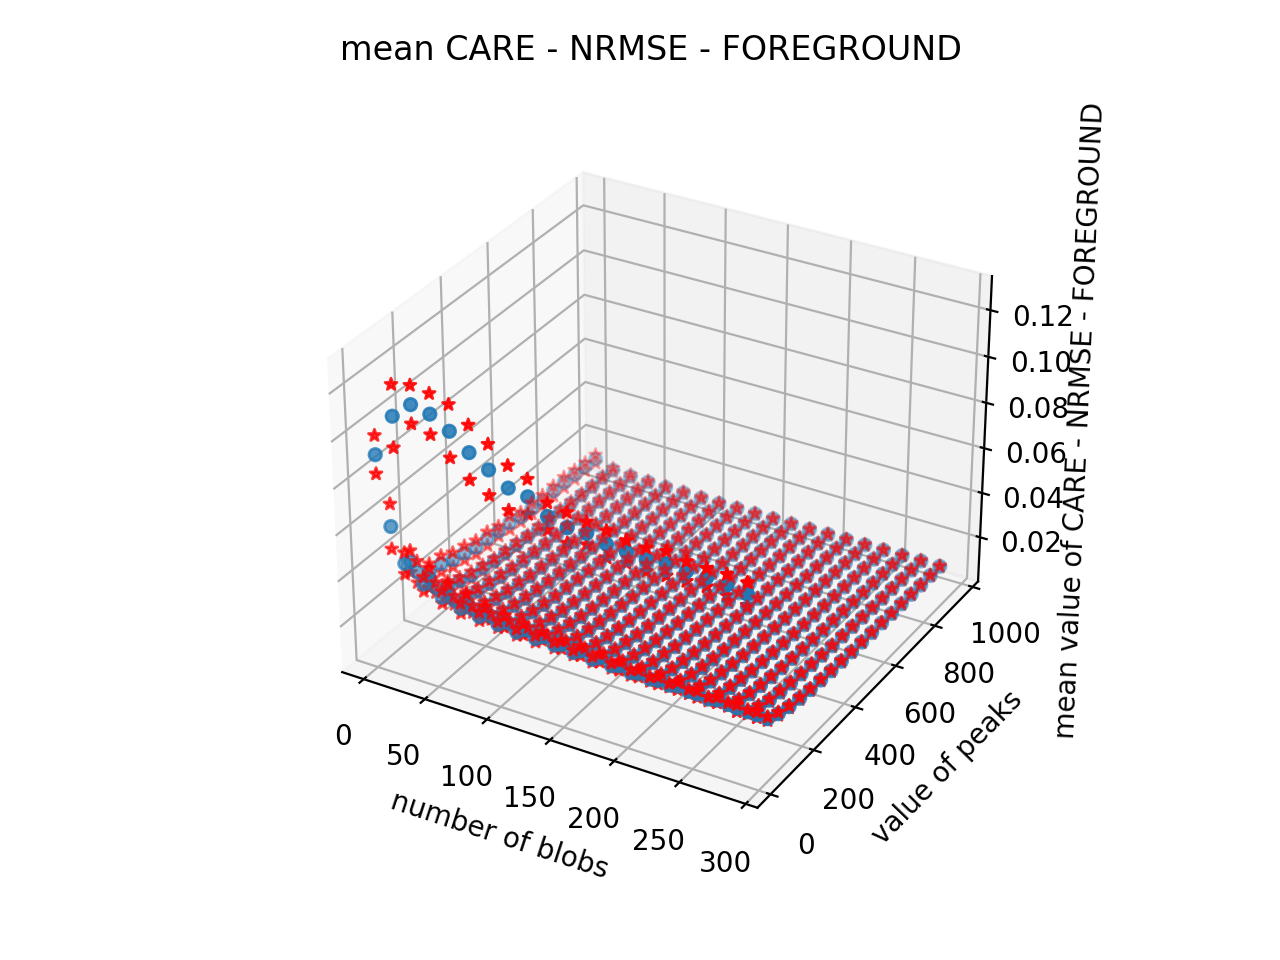

<IPython.core.display.Javascript object>


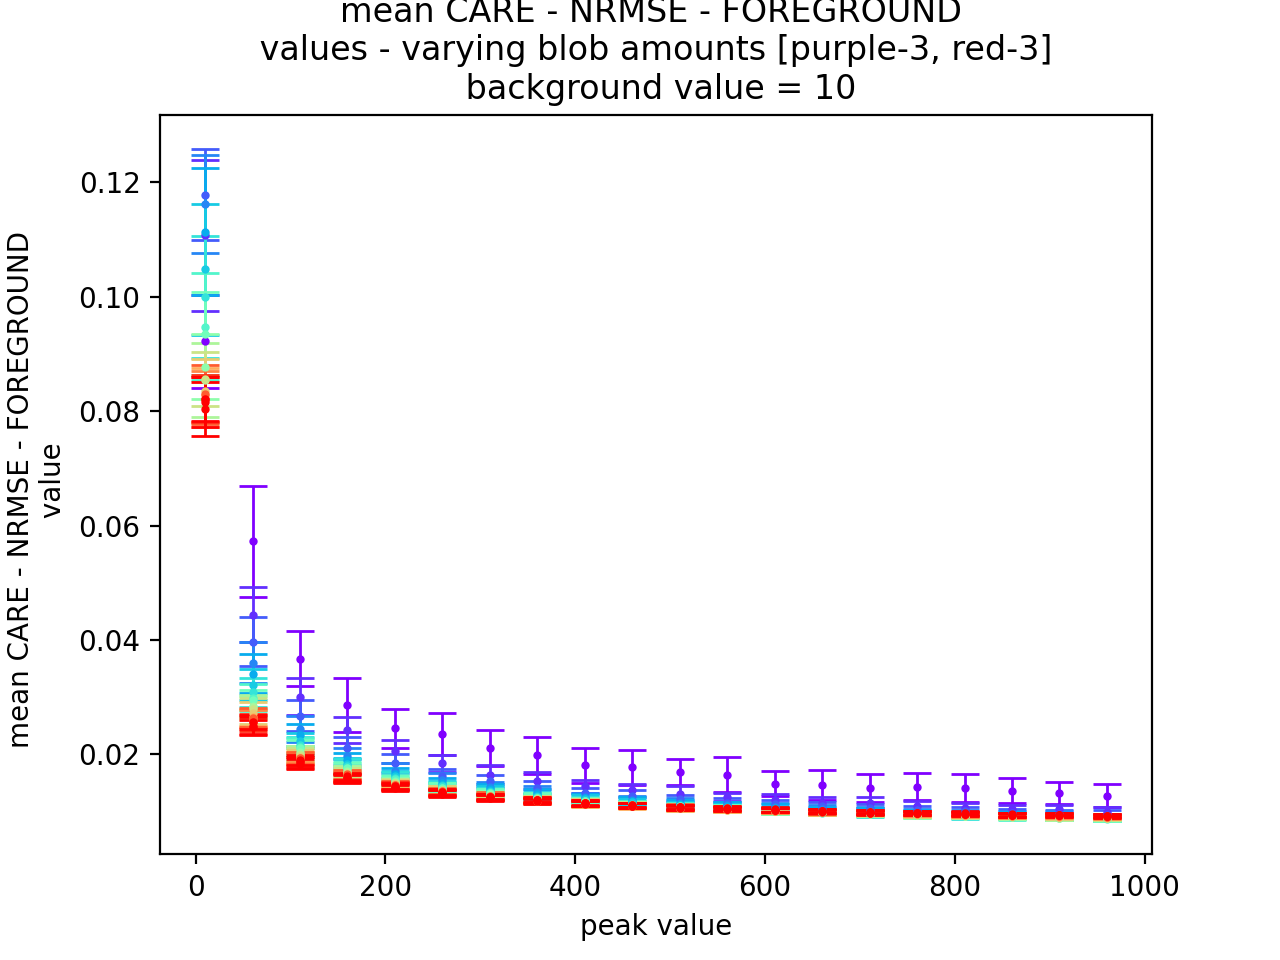

<IPython.core.display.Javascript object>


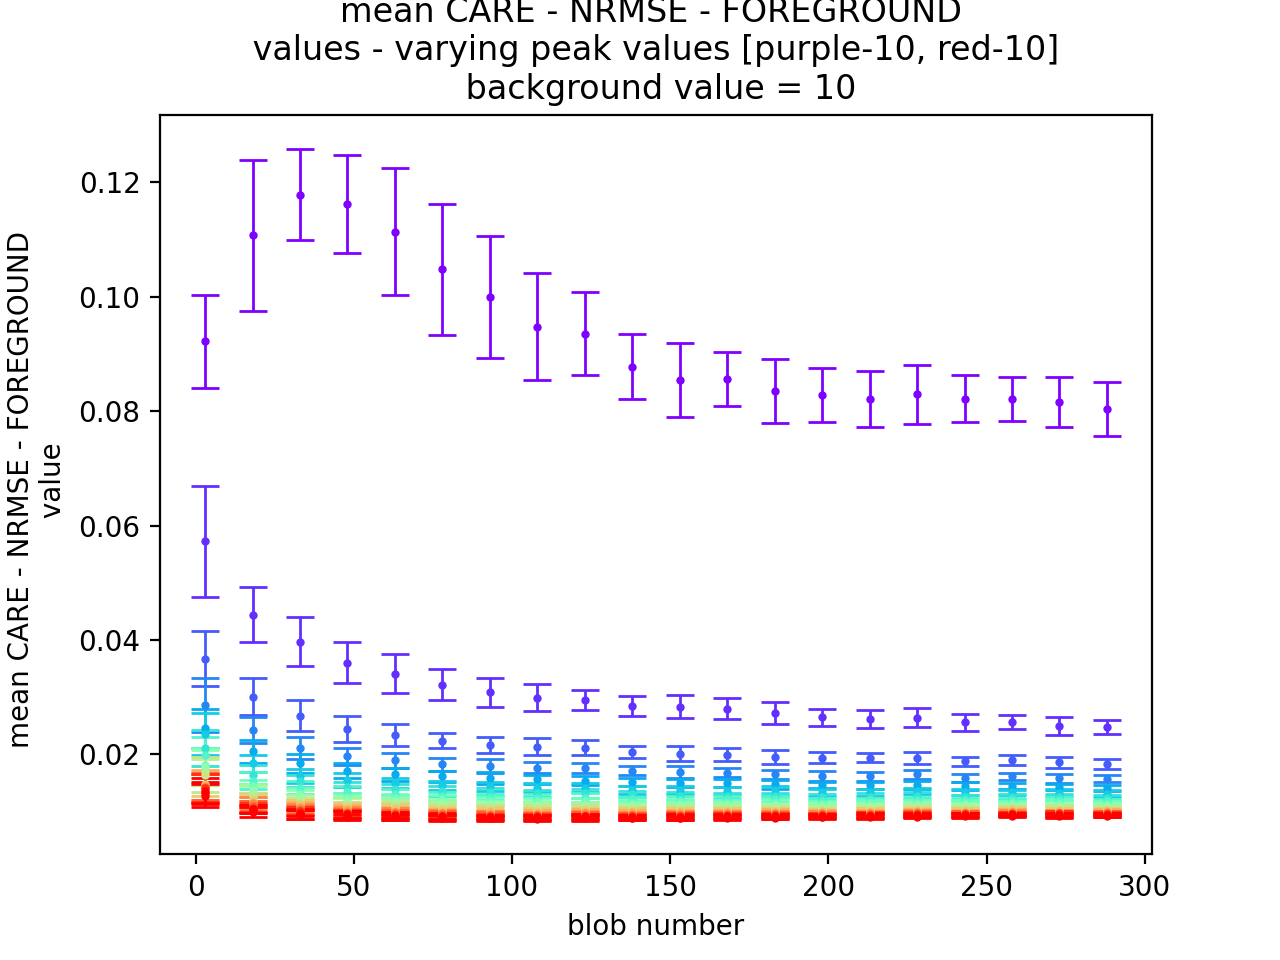

In [34]:
# CARE: -NRMSE FOREGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_NRMSE_CARE_beam_foreground, indices_eval, 'CARE - NRMSE - FOREGROUND \n')

<IPython.core.display.Javascript object>


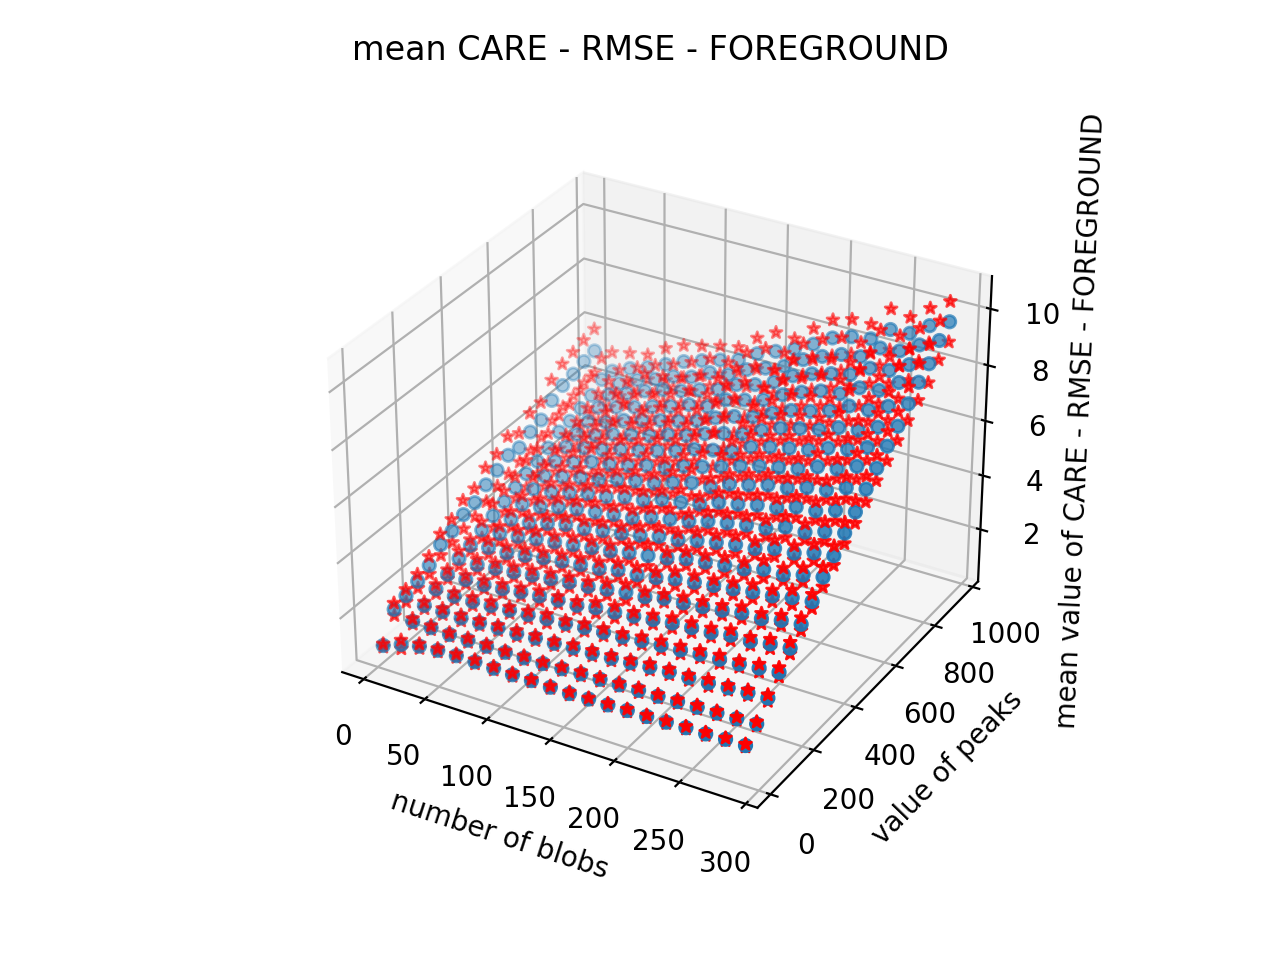

<IPython.core.display.Javascript object>


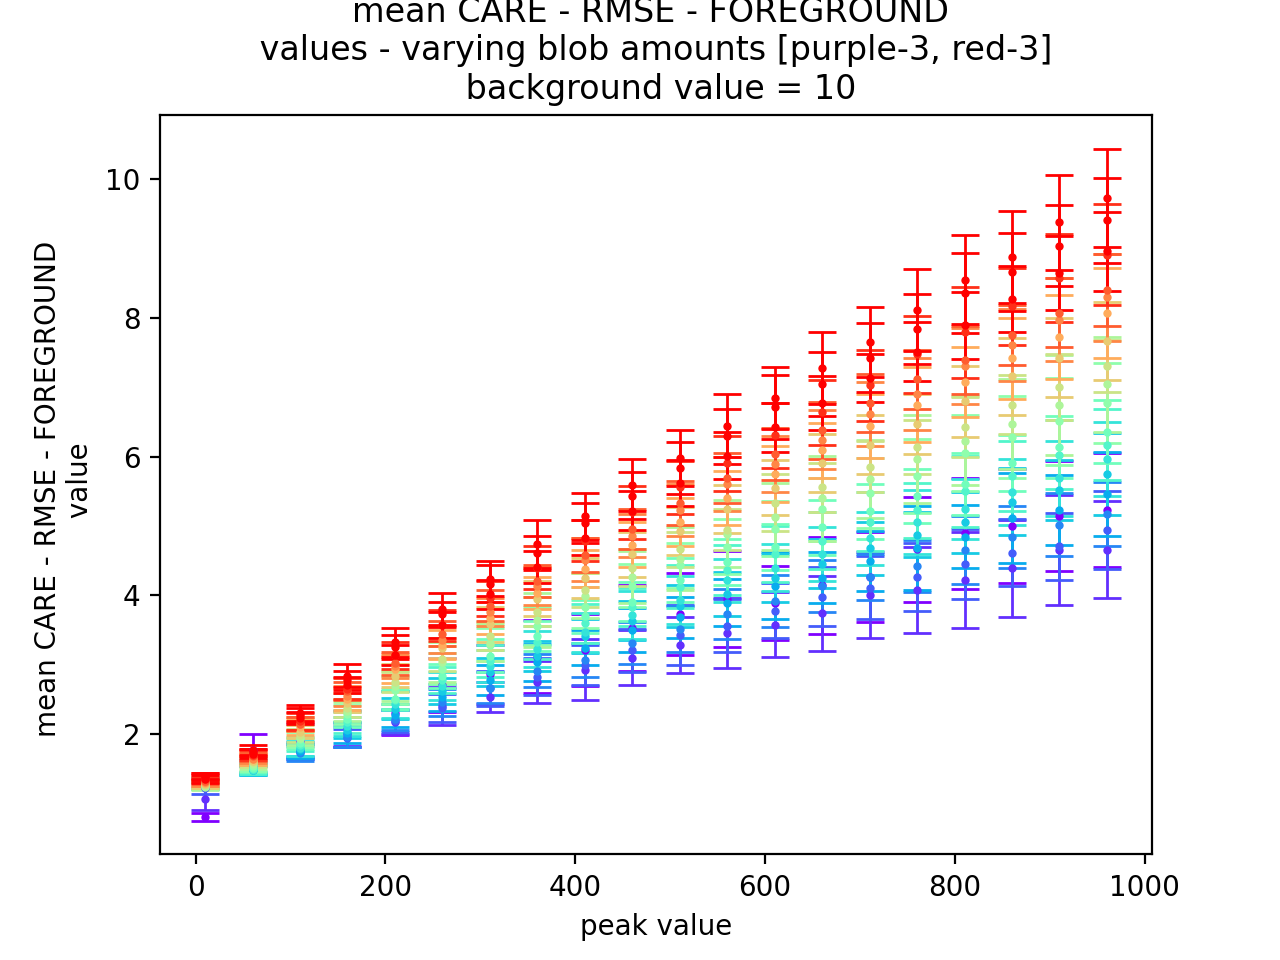

<IPython.core.display.Javascript object>


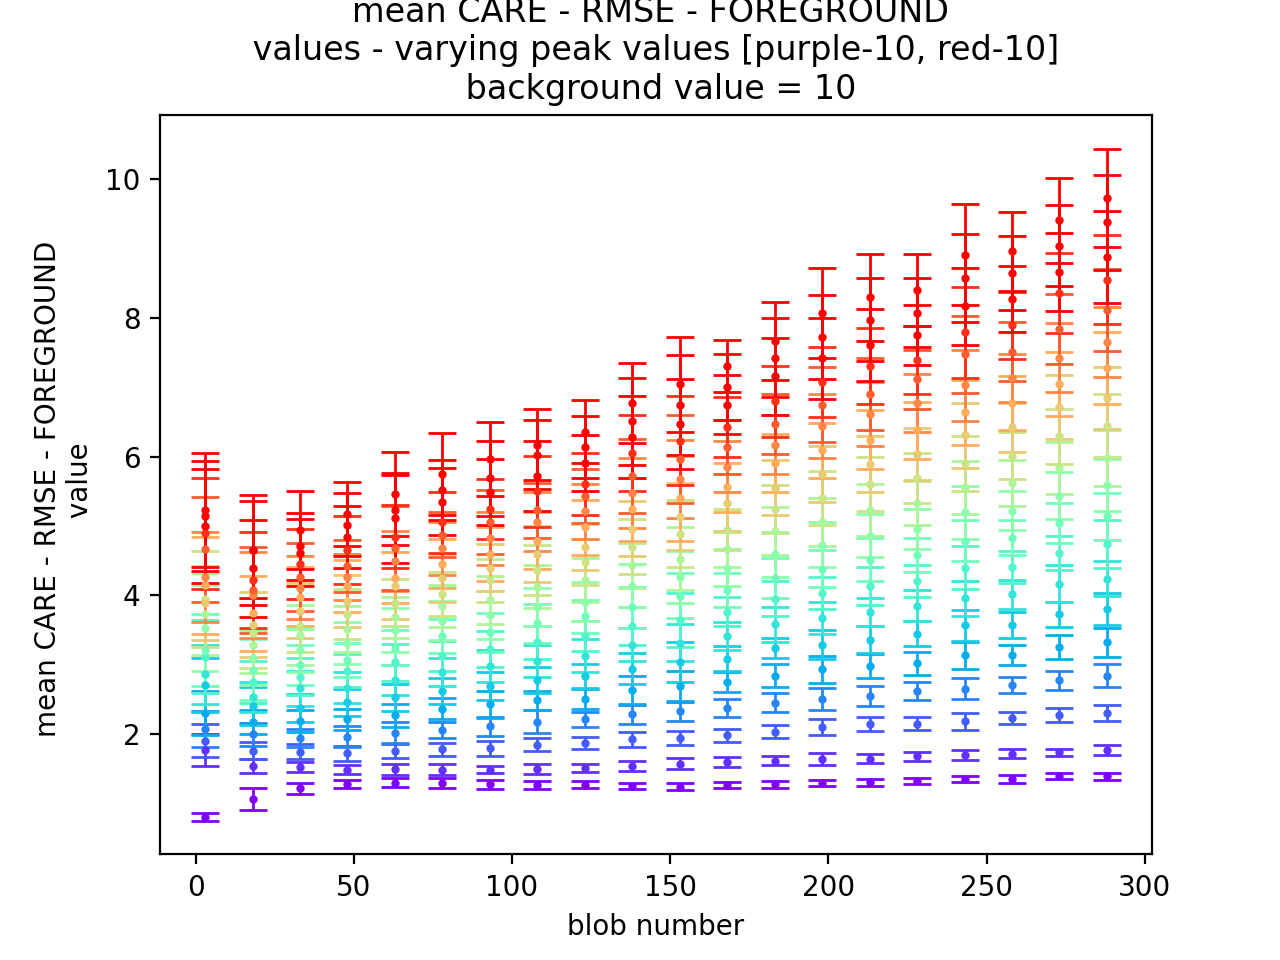

In [35]:
# N2V: -RMSE FOREGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_RMSE_CARE_beam_foreground, indices_eval, 'CARE - RMSE - FOREGROUND \n')

<IPython.core.display.Javascript object>


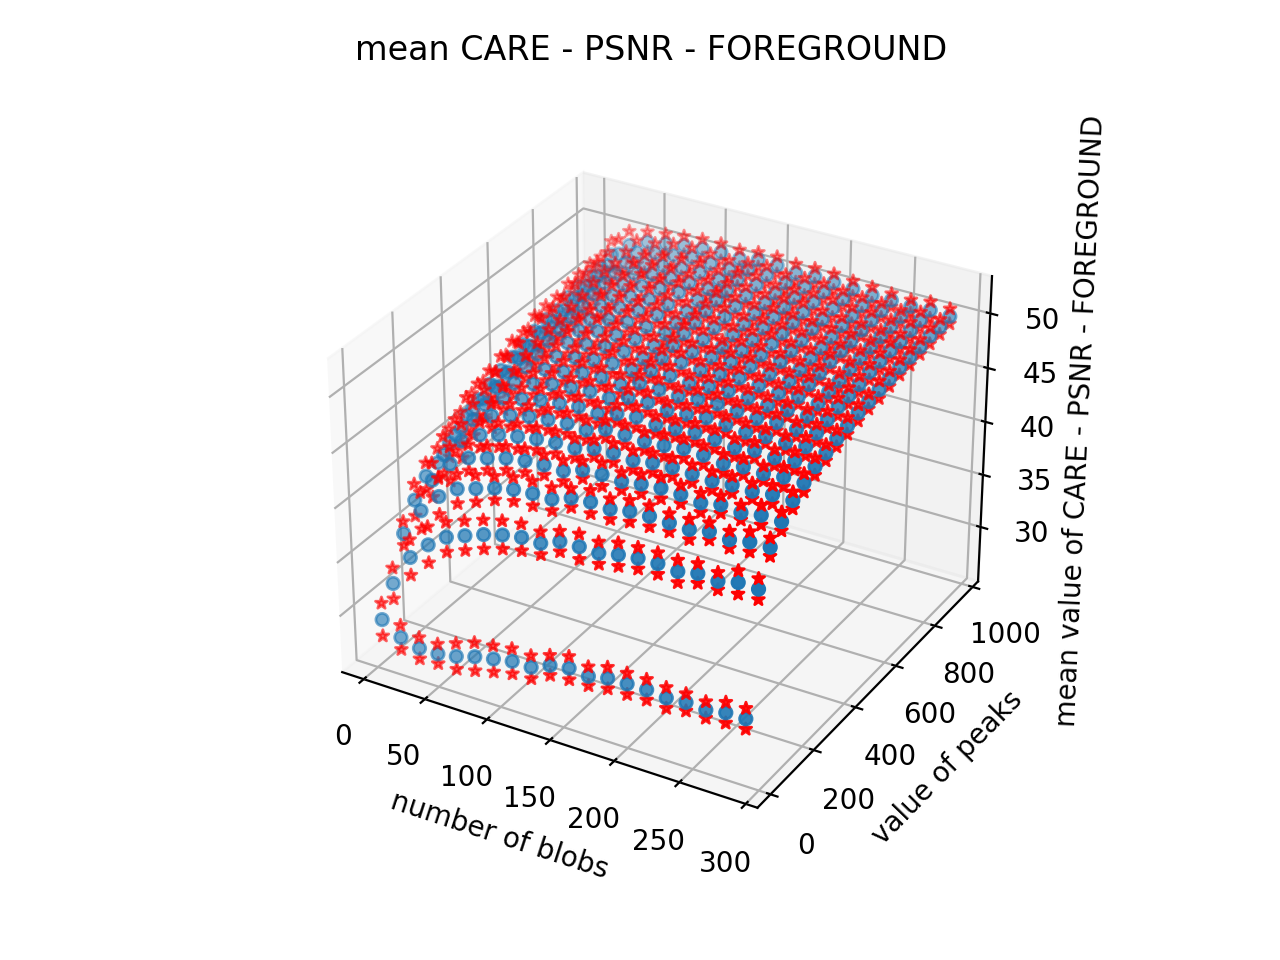

<IPython.core.display.Javascript object>


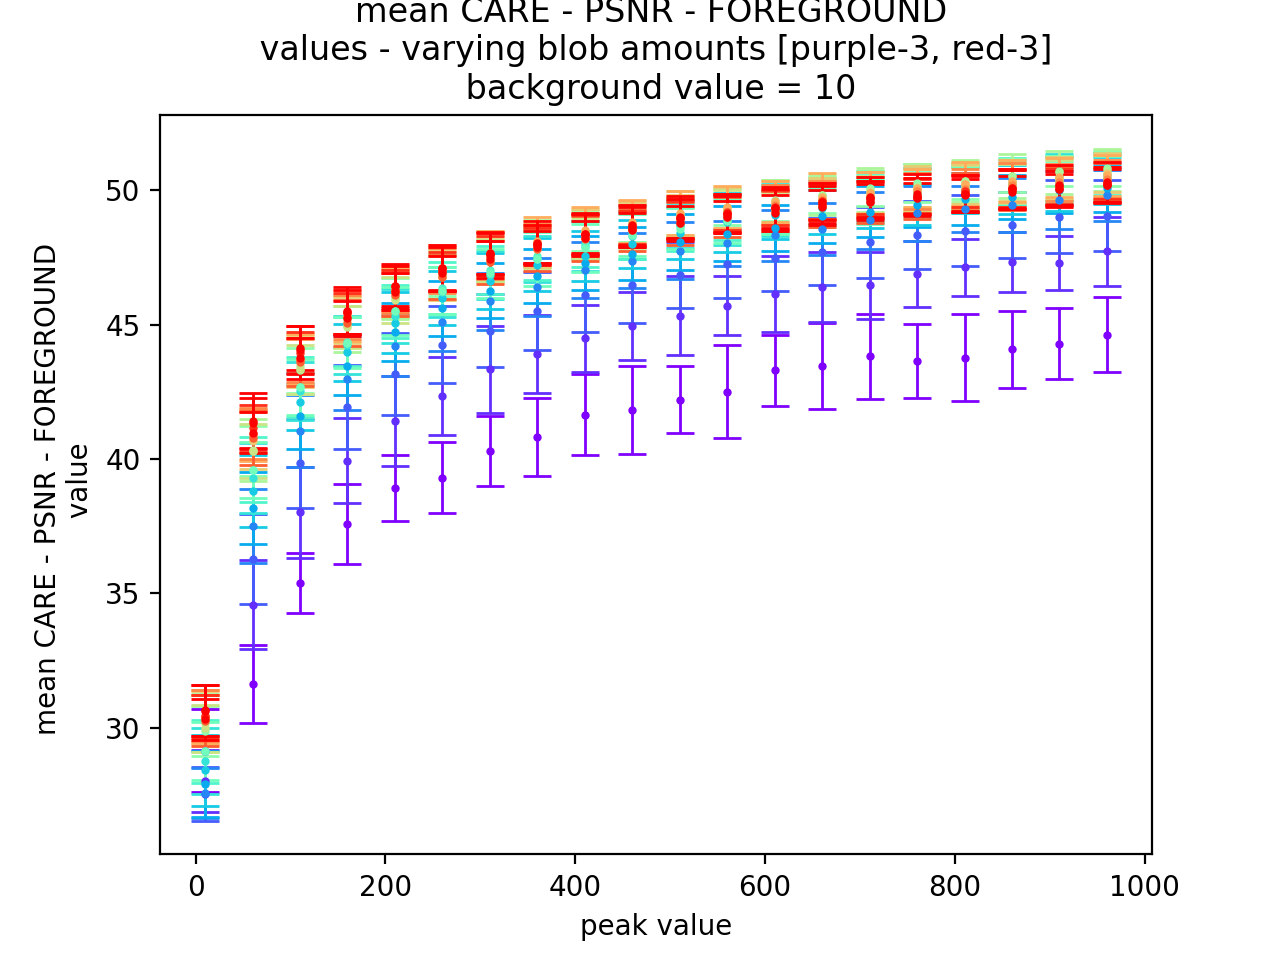

<IPython.core.display.Javascript object>


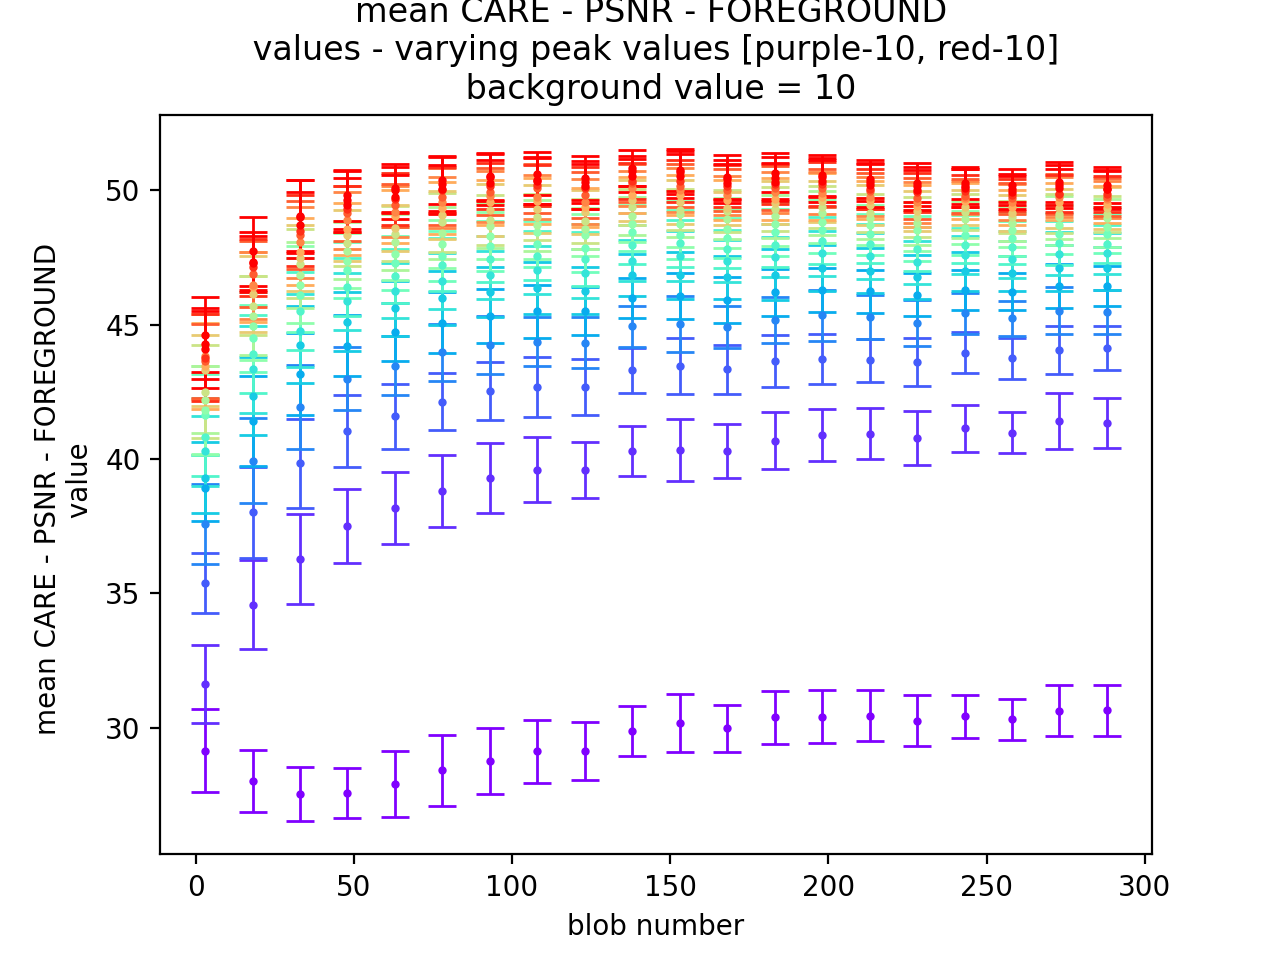

In [36]:
# N2V: -PSNR FOREGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_PSNR_CARE_beam_foreground, indices_eval, 'CARE - PSNR - FOREGROUND \n')

<IPython.core.display.Javascript object>


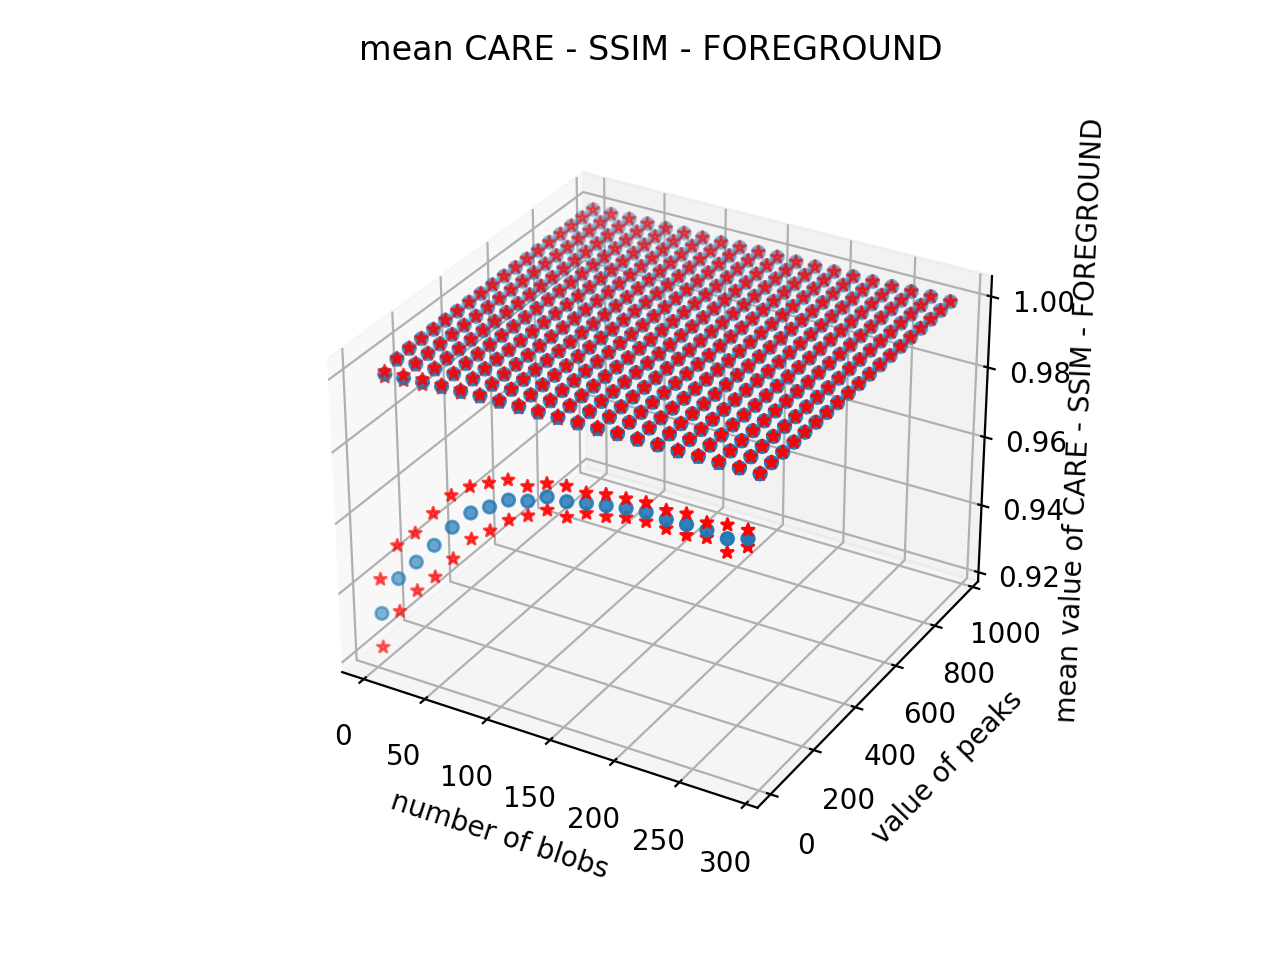

<IPython.core.display.Javascript object>


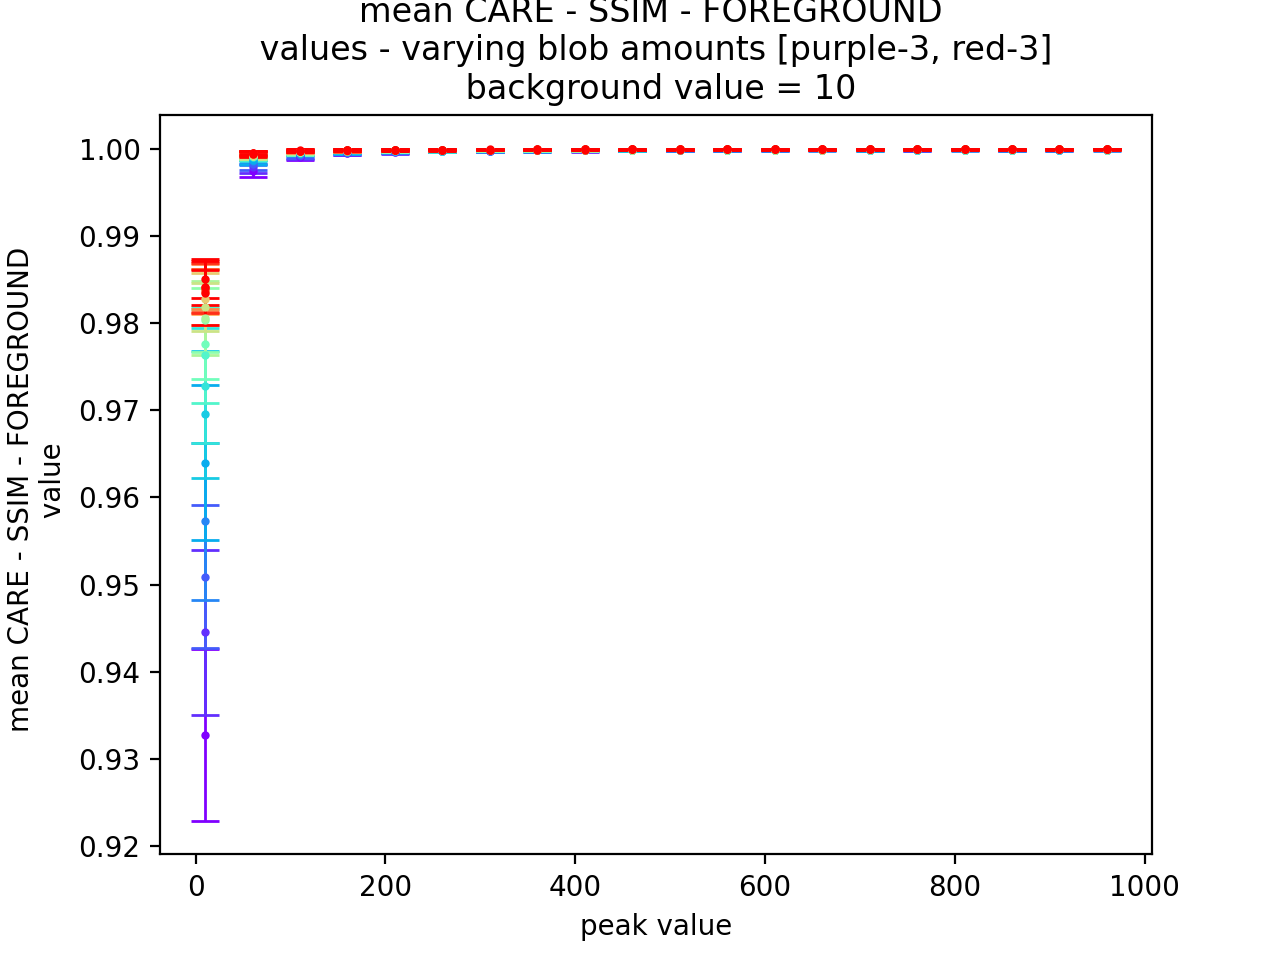

<IPython.core.display.Javascript object>


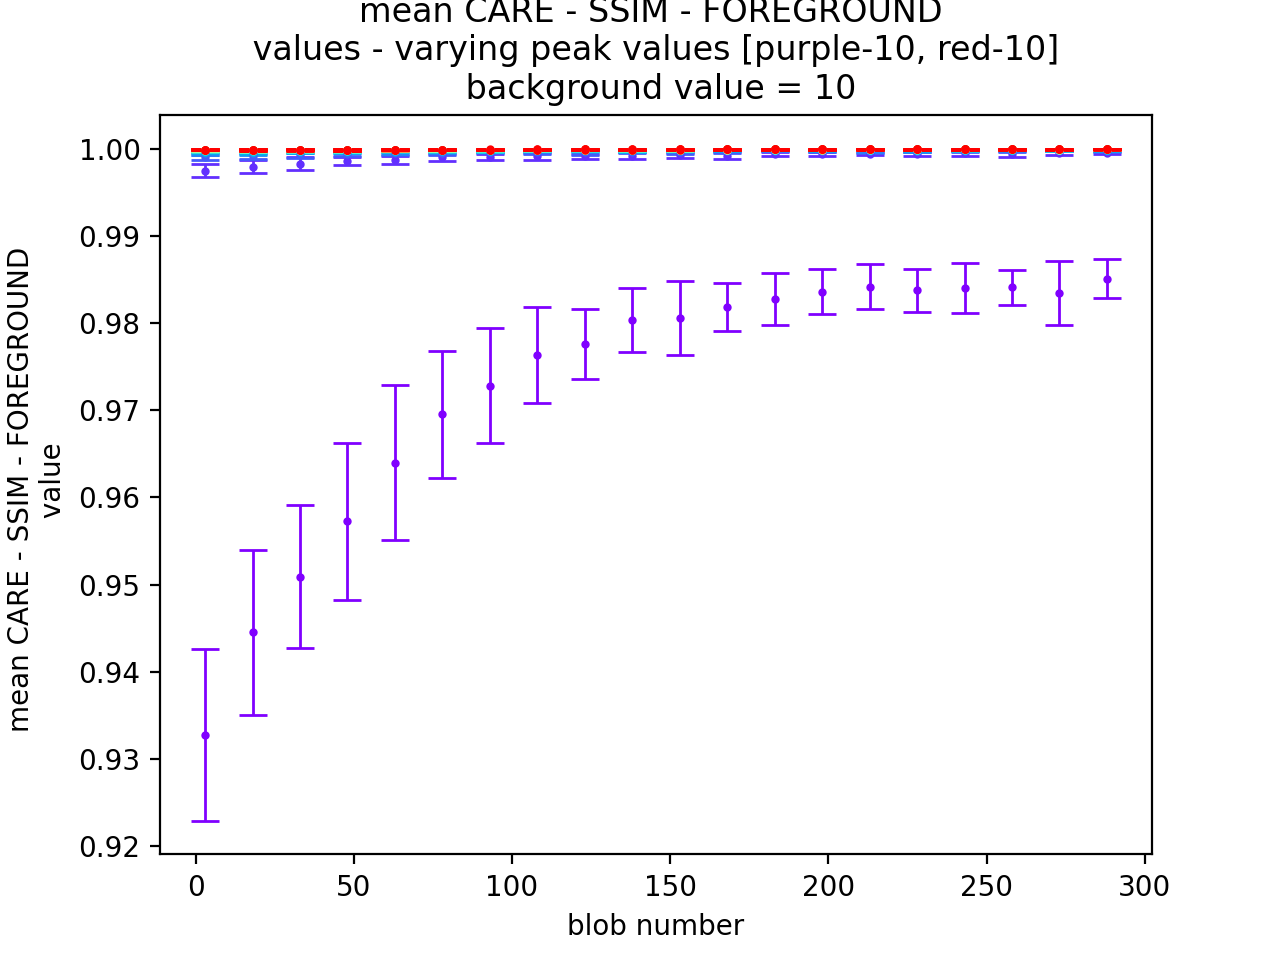

In [37]:
# N2V: -SSIM FOREGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_SSIM_CARE_beam_foreground, indices_eval, 'CARE - SSIM - FOREGROUND \n')